In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
torch.manual_seed(62)
device = "cuda" if torch.cuda.is_available() else "cpu"

train_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(128, scale=(0.7, 1.0)),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

val_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=(128, 128)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_dataset = torchvision.datasets.Imagenette(
    "../../datasets", split="train", download=True, transform=train_transforms
)
val_dataset = torchvision.datasets.Imagenette(
    "../../datasets", split="val", download=True, transform=val_transforms
)
val_dataset, test_dataset = random_split(
    val_dataset,
    lengths=[
        int(len(val_dataset) / 3 * 2),
        len(val_dataset) - int(len(val_dataset) / 3 * 2),
    ],
)

device

'cuda'

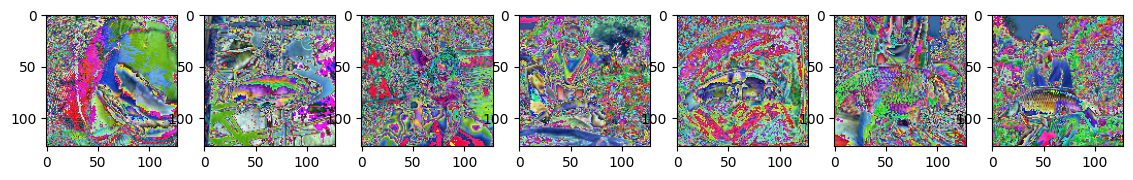

In [3]:
def show_in_row(dataset):
    plt.figure(figsize=(20, 8))
    for i in range(7):
        plt.subplot(1, 10, i + 1)
        plt.imshow(v2.ToPILImage()(dataset[i][0]))
    plt.show()


show_in_row(train_dataset)

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes, fe_dropout=0.1, cl_dropout=0.5):
        super(CNN, self).__init__()

        # Feature Extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1),  # 62x62x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 30x30x64
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 30x30x192
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 14x14x192
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 14x14x384
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 14x14x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 14x14x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 6x6x256
            nn.Dropout(p=fe_dropout),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=cl_dropout),
            nn.Linear(256 * 6 * 6, 4096),  # FC1
            nn.ReLU(inplace=True),
            nn.Dropout(p=cl_dropout),
            nn.Linear(4096, 4096),  # FC2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # FC3
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
num_epochs = 80
batch_size = 64
learning_rate = 3e-4
out_classes = 10
checkpoint_step = 5

model = CNN(out_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30)
writer = SummaryWriter(
    "logs/Imagenette/LR {} BS {} SCHEDULED".format(learning_rate, batch_size)
)

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=6,
    persistent_workers=True,
)
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=6,
    persistent_workers=True,
)
testloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

In [21]:
step = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(trainloader):
        step += 1
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        writer.add_scalar("Trainning Loss", loss, global_step=step)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}"
    )

    model.eval()
    total, correct = 0, 0
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_val_loss += val_loss.item()

    accuracy = 100 * correct / total

    writer.add_scalar("Validation Loss", val_loss, global_step=step)
    writer.add_scalar("Accuracy", accuracy, global_step=step)

    print(
        f"Accuracy: {accuracy:.2f}% Validation Loss: {running_val_loss / len(valloader):.4f}"
    )

    scheduler.step(val_loss)

    if (epoch + 1) % checkpoint_step == 0:
        torch.save(
            {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": loss,
                "val_loss": val_loss,
                "accuracy": accuracy,
            },
            f"epoch_{epoch + 1}.pth",
        )

        print(f"Epoch #{epoch + 1} saved")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:19<00:00,  7.46it/s]


Epoch [1/80], Loss: 1.6522


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:13<00:00,  3.03it/s]
C:\Users\20msk\AppData\Local\Temp\ipykernel_22216\2303867825.py:49: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  scheduler.step(val_loss)


Accuracy: 42.20% Validation Loss: 1.8275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.59it/s]


Epoch [2/80], Loss: 1.1232


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 26.25it/s]


Accuracy: 62.42% Validation Loss: 1.1779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.77it/s]


Epoch [3/80], Loss: 0.9665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.02it/s]


Accuracy: 68.92% Validation Loss: 0.9635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.73it/s]


Epoch [4/80], Loss: 0.8733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.01it/s]


Accuracy: 69.46% Validation Loss: 0.9487


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.69it/s]


Epoch [5/80], Loss: 0.7785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.93it/s]


Accuracy: 70.37% Validation Loss: 0.9266
Epoch #5 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.67it/s]


Epoch [6/80], Loss: 0.7370


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.35it/s]


Accuracy: 67.78% Validation Loss: 1.0696


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.73it/s]


Epoch [7/80], Loss: 0.6841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.76it/s]


Accuracy: 72.71% Validation Loss: 0.8520


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.69it/s]


Epoch [8/80], Loss: 0.6393


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.19it/s]


Accuracy: 75.84% Validation Loss: 0.7615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.71it/s]


Epoch [9/80], Loss: 0.6146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.70it/s]


Accuracy: 74.62% Validation Loss: 0.8130


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.78it/s]


Epoch [10/80], Loss: 0.5734


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.19it/s]


Accuracy: 77.48% Validation Loss: 0.7186
Epoch #10 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.72it/s]


Epoch [11/80], Loss: 0.5542


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.07it/s]


Accuracy: 73.47% Validation Loss: 0.8549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.53it/s]


Epoch [12/80], Loss: 0.5166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 23.49it/s]


Accuracy: 77.98% Validation Loss: 0.6810


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.26it/s]


Epoch [13/80], Loss: 0.4806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.66it/s]


Accuracy: 79.32% Validation Loss: 0.6423


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.55it/s]


Epoch [14/80], Loss: 0.4808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.62it/s]


Accuracy: 75.54% Validation Loss: 0.7992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.55it/s]


Epoch [15/80], Loss: 0.4346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.88it/s]


Accuracy: 78.82% Validation Loss: 0.6871
Epoch #15 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.78it/s]


Epoch [16/80], Loss: 0.4245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.95it/s]


Accuracy: 78.82% Validation Loss: 0.6800


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.56it/s]


Epoch [17/80], Loss: 0.3953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.46it/s]


Accuracy: 76.49% Validation Loss: 0.7729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.75it/s]


Epoch [18/80], Loss: 0.3792


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.38it/s]


Accuracy: 77.56% Validation Loss: 0.7651


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.46it/s]


Epoch [19/80], Loss: 0.3708


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.95it/s]


Accuracy: 79.59% Validation Loss: 0.7064


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.71it/s]


Epoch [20/80], Loss: 0.3546


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.66it/s]


Accuracy: 78.48% Validation Loss: 0.7592
Epoch #20 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.26it/s]


Epoch [21/80], Loss: 0.3468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.10it/s]


Accuracy: 75.04% Validation Loss: 0.9592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.40it/s]


Epoch [22/80], Loss: 0.3127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.47it/s]


Accuracy: 80.08% Validation Loss: 0.6673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.37it/s]


Epoch [23/80], Loss: 0.3041


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.18it/s]


Accuracy: 82.00% Validation Loss: 0.6296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 17.95it/s]


Epoch [24/80], Loss: 0.2731


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 23.16it/s]


Accuracy: 75.96% Validation Loss: 0.9304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.81it/s]


Epoch [25/80], Loss: 0.2861


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 22.89it/s]


Accuracy: 77.52% Validation Loss: 0.8349
Epoch #25 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.47it/s]


Epoch [26/80], Loss: 0.2620


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.20it/s]


Accuracy: 81.00% Validation Loss: 0.6729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.68it/s]


Epoch [27/80], Loss: 0.2470


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.21it/s]


Accuracy: 81.77% Validation Loss: 0.6426


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.78it/s]


Epoch [28/80], Loss: 0.2447


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.43it/s]


Accuracy: 81.54% Validation Loss: 0.6566


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.43it/s]


Epoch [29/80], Loss: 0.2357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.55it/s]


Accuracy: 79.82% Validation Loss: 0.8041


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.68it/s]


Epoch [30/80], Loss: 0.2134


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.49it/s]


Accuracy: 79.05% Validation Loss: 0.7596
Epoch #30 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.55it/s]


Epoch [31/80], Loss: 0.2127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.89it/s]


Accuracy: 80.35% Validation Loss: 0.7896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.55it/s]


Epoch [32/80], Loss: 0.2139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.71it/s]


Accuracy: 78.56% Validation Loss: 0.8368


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.49it/s]


Epoch [33/80], Loss: 0.1900


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.46it/s]


Accuracy: 80.31% Validation Loss: 0.8082


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.11it/s]


Epoch [34/80], Loss: 0.1894


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.43it/s]


Accuracy: 81.54% Validation Loss: 0.7157


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.09it/s]


Epoch [35/80], Loss: 0.1822


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.41it/s]


Accuracy: 79.97% Validation Loss: 0.8266
Epoch #35 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.47it/s]


Epoch [36/80], Loss: 0.1828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.48it/s]


Accuracy: 79.55% Validation Loss: 0.8773


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.51it/s]


Epoch [37/80], Loss: 0.1787


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.14it/s]


Accuracy: 81.61% Validation Loss: 0.7101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.49it/s]


Epoch [38/80], Loss: 0.1641


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.74it/s]


Accuracy: 82.61% Validation Loss: 0.6567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.84it/s]


Epoch [39/80], Loss: 0.1528


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.39it/s]


Accuracy: 79.63% Validation Loss: 0.8703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.67it/s]


Epoch [40/80], Loss: 0.1473


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.57it/s]


Accuracy: 83.03% Validation Loss: 0.7106
Epoch #40 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.61it/s]


Epoch [41/80], Loss: 0.1339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.31it/s]


Accuracy: 82.84% Validation Loss: 0.7450


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.64it/s]


Epoch [42/80], Loss: 0.1491


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.77it/s]


Accuracy: 82.07% Validation Loss: 0.7120


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.55it/s]


Epoch [43/80], Loss: 0.1359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.52it/s]


Accuracy: 80.93% Validation Loss: 0.7787


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.67it/s]


Epoch [44/80], Loss: 0.1163


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.72it/s]


Accuracy: 80.93% Validation Loss: 0.9217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.74it/s]


Epoch [45/80], Loss: 0.1167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.92it/s]


Accuracy: 81.65% Validation Loss: 0.8245
Epoch #45 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.13it/s]


Epoch [46/80], Loss: 0.1270


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.33it/s]


Accuracy: 82.34% Validation Loss: 0.7484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.91it/s]


Epoch [47/80], Loss: 0.1169


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.71it/s]


Accuracy: 81.73% Validation Loss: 0.7592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.79it/s]


Epoch [48/80], Loss: 0.1084


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.51it/s]


Accuracy: 83.33% Validation Loss: 0.7932


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.83it/s]


Epoch [49/80], Loss: 0.1224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.62it/s]


Accuracy: 80.54% Validation Loss: 0.8584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.87it/s]


Epoch [50/80], Loss: 0.1112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.58it/s]


Accuracy: 80.62% Validation Loss: 0.9409
Epoch #50 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.76it/s]


Epoch [51/80], Loss: 0.1108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.68it/s]


Accuracy: 82.30% Validation Loss: 0.7330


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.46it/s]


Epoch [52/80], Loss: 0.1141


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.56it/s]


Accuracy: 82.49% Validation Loss: 0.7750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.65it/s]


Epoch [53/80], Loss: 0.1007


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.54it/s]


Accuracy: 81.38% Validation Loss: 0.7751


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.80it/s]


Epoch [54/80], Loss: 0.0975


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.80it/s]


Accuracy: 80.77% Validation Loss: 0.8182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.86it/s]


Epoch [55/80], Loss: 0.0915


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.57it/s]


Accuracy: 78.71% Validation Loss: 1.1475
Epoch #55 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.80it/s]


Epoch [56/80], Loss: 0.0955


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.39it/s]


Accuracy: 83.83% Validation Loss: 0.6882


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.65it/s]


Epoch [57/80], Loss: 0.0866


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.33it/s]


Accuracy: 82.38% Validation Loss: 0.8020


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.59it/s]


Epoch [58/80], Loss: 0.0941


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.63it/s]


Accuracy: 81.61% Validation Loss: 0.8070


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.46it/s]


Epoch [59/80], Loss: 0.0923


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.57it/s]


Accuracy: 82.87% Validation Loss: 0.7865


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.61it/s]


Epoch [60/80], Loss: 0.0827


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.04it/s]


Accuracy: 82.34% Validation Loss: 0.8365
Epoch #60 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.80it/s]


Epoch [61/80], Loss: 0.0958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.55it/s]


Accuracy: 82.95% Validation Loss: 0.7255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.83it/s]


Epoch [62/80], Loss: 0.0832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.08it/s]


Accuracy: 83.22% Validation Loss: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.28it/s]


Epoch [63/80], Loss: 0.0790


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.52it/s]


Accuracy: 82.30% Validation Loss: 0.8091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.22it/s]


Epoch [64/80], Loss: 0.0808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.14it/s]


Accuracy: 82.87% Validation Loss: 0.8214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.31it/s]


Epoch [65/80], Loss: 0.0829


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.39it/s]


Accuracy: 82.38% Validation Loss: 0.8403
Epoch #65 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 17.45it/s]


Epoch [66/80], Loss: 0.0781


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 23.75it/s]


Accuracy: 82.95% Validation Loss: 0.8011


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.42it/s]


Epoch [67/80], Loss: 0.0837


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.03it/s]


Accuracy: 82.22% Validation Loss: 0.7937


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 17.86it/s]


Epoch [68/80], Loss: 0.0795


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 23.41it/s]


Accuracy: 81.77% Validation Loss: 0.8354


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.67it/s]


Epoch [69/80], Loss: 0.0667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.94it/s]


Accuracy: 81.27% Validation Loss: 0.9022


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.62it/s]


Epoch [70/80], Loss: 0.0748


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 26.51it/s]


Accuracy: 83.07% Validation Loss: 0.7258
Epoch #70 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.31it/s]


Epoch [71/80], Loss: 0.0781


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.79it/s]


Accuracy: 82.53% Validation Loss: 0.8577


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.92it/s]


Epoch [72/80], Loss: 0.0768


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 26.10it/s]


Accuracy: 82.49% Validation Loss: 0.8107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.42it/s]


Epoch [73/80], Loss: 0.0710


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.34it/s]


Accuracy: 82.53% Validation Loss: 0.7830


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 19.35it/s]


Epoch [74/80], Loss: 0.0871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.04it/s]


Accuracy: 82.42% Validation Loss: 0.8019


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.99it/s]


Epoch [75/80], Loss: 0.0704


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 23.15it/s]


Accuracy: 82.19% Validation Loss: 0.8654
Epoch #75 saved


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 17.47it/s]


Epoch [76/80], Loss: 0.0507


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 23.34it/s]


Accuracy: 84.25% Validation Loss: 0.7900


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.63it/s]


Epoch [77/80], Loss: 0.0689


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.25it/s]


Accuracy: 83.07% Validation Loss: 0.8356


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.54it/s]


Epoch [78/80], Loss: 0.0655


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.08it/s]


Accuracy: 81.23% Validation Loss: 0.9060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 18.10it/s]


Epoch [79/80], Loss: 0.0623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.50it/s]


Accuracy: 81.19% Validation Loss: 0.8554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:07<00:00, 18.55it/s]


Epoch [80/80], Loss: 0.0644


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 24.45it/s]


Accuracy: 83.52% Validation Loss: 0.7448
Epoch #80 saved


In [16]:
model.eval()
total, correct = 0, 0
running_test_loss = 0.0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        test_loss = criterion(outputs, labels)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_test_loss += test_loss.item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}% Test Loss: {running_test_loss / len(testloader):.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.08it/s]

Accuracy: 85.87% Test Loss: 0.6685
